# Stroop Task Reaction Time Analysis
This project analyzes data from a Stroop test, a classic cognitive psychology experiment designed to assess selective attention, cognitive control, and processing interference.

## What is the Stroop effect?
The Stroop effect is a psychological phenomenon that demonstrates the interference between automatic and controlled processes in the brain.

In its most common example, it is observed that participants in a **Stroop test** take longer to name the colour of ink in which a word is printed, when the colour of the ink and the word itself are incongruent.

## Overview
Participants were shown words naming colours, either:

**Congruent**: word and ink colour match (e.g., “Red” in red ink)

**Incongruent**: word and ink colour mismatch (e.g., “Blue” in green ink)

They were asked to identify the colour of the ink, not read the word. The reaction times for each trial were recorded and analyzed to measure interference effects. 

**To view the test:** https://stroop-test.onrender.com


In [2]:
#Importing libraries
import pandas as pd 
import numpy as np

import scipy
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from scipy.stats import linregress

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

import sklearn as sk
from sklearn.linear_model import LogisticRegression

# Formatting raw data 

The raw data was stored in a database "stroop_results_final.csv" and is also visible at https://stroop-test.onrender.com/data. 

In [4]:
# Creating dataframe
df = pd.read_csv("stroop_results_final.csv") 
df = df.drop(columns=df.columns[0])
df["is_correct"] = df["is_correct"].astype(int)

#Checking for missing data
assert not df.isnull().values.any(), "Missing values found in the dataset."

print(df.columns)
print(f"Total number of results: {len(df)}")

Index(['word', 'color', 'response', 'reaction_time', 'is_correct', 'time'], dtype='object')
Total number of results: 1270


**NOTE: Participant IDs were not originally recorded.**
I assume that each block of 20 trials corresponds to one participant (in the order data was collected). However, this method relies on the data being unshuffled and complete.

### 📌 Modifying dataframe

In [6]:
# Dividing based on id
df["participant_id"] = df.index // 20

# Adding congruent column
df["is_congruent"] = df["word"].str.lower() == df["color"]
df["is_congruent"] = df["is_congruent"].astype(int)

# Filtering invalid values 
df = df[(df["reaction_time"] >= 200) & (df["reaction_time"] <= 3000)]

# Modified dataframe
print(df.head())
print(len(df))

    word   color response  reaction_time  is_correct                   time  \
0    RED     red      red         2124.0           1  Apr 02, 2025 08:44 AM   
1    RED  yellow   yellow         2326.0           1  Apr 02, 2025 08:44 AM   
3    RED  yellow   yellow         2004.0           1  Apr 02, 2025 08:44 AM   
4    RED  yellow   yellow         2924.0           1  Apr 02, 2025 08:44 AM   
6  GREEN     red      red         1804.0           1  Apr 02, 2025 08:44 AM   

   participant_id  is_congruent  
0               0             1  
1               0             0  
3               0             0  
4               0             0  
6               0             0  
1049


 ## Trial Level Overview:

### 📌 Mean, median, standard deviation and percentage accuracy of trial level data:

In [8]:
# Mean, median, standard deviation, percentage accuracy
reaction_times = df["reaction_time"]
mean_rt = np.mean(reaction_times)
median_rt = np.median(reaction_times)
std_rt = np.std(reaction_times)

accuracy = df["is_correct"].mean() * 100

print(f"Mean Reaction Time: {mean_rt:.3f} ms")
print(f"Median Reaction Time: {median_rt:.3f} ms")
print(f"Standard Deviation: {std_rt:.3f} ms")
print(f"Percentage Accuracy (Ungrouped): {accuracy:.3f}%")

Mean Reaction Time: 1859.940 ms
Median Reaction Time: 1812.000 ms
Standard Deviation: 508.825 ms
Percentage Accuracy (Ungrouped): 91.611%


### 📌 Histogram:

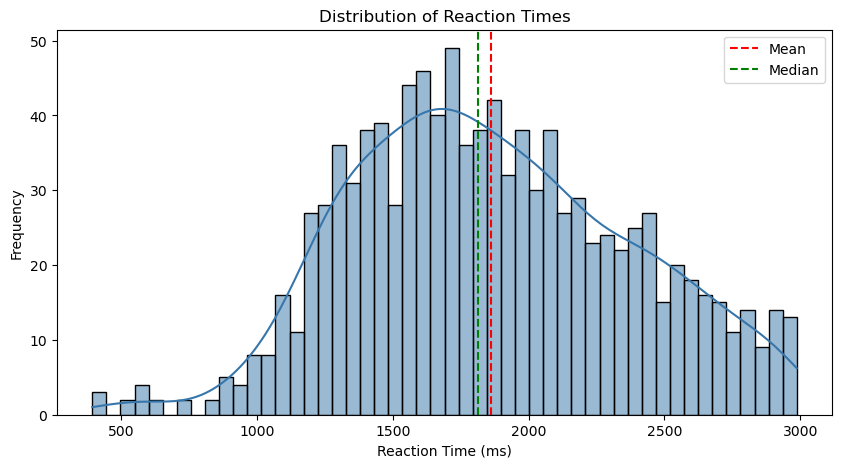

In [144]:
plt.figure(figsize=(10, 5))
sns.histplot(df["reaction_time"], bins=50, kde=True, color="#3776ab")
plt.axvline(mean_rt, color="red", linestyle='--', label='Mean')
plt.axvline(median_rt, color="green", linestyle='--', label='Median')
plt.xlabel("Reaction Time (ms)")
plt.ylabel("Frequency")
plt.title("Distribution of Reaction Times")
plt.legend()
plt.show() 

### 📌 Boxplot:

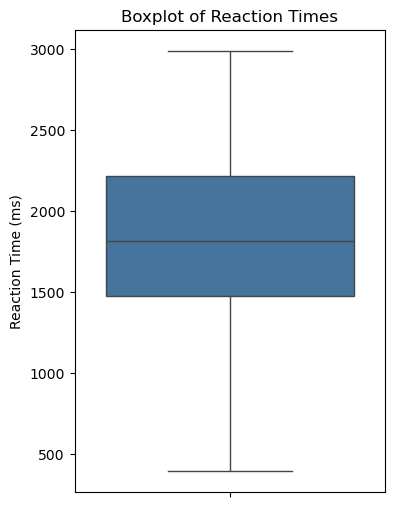

In [147]:
plt.figure(figsize=(4, 6))
sns.boxplot(y=df["reaction_time"], color="#3776ab")
plt.ylabel("Reaction Time (ms)")
plt.title("Boxplot of Reaction Times")
plt.show()

## Participant Level Summary 

A table displaying mean reaction time, standard deviation of reaction time, and percentage accuracy for each participant.

In [12]:
# Summary stats per participant
participant_summary = df.groupby("participant_id").agg(
    mean_rt=("reaction_time", "mean"),
    std_rt=("reaction_time", "std"),
    accuracy=("is_correct", "mean")
).reset_index() 
print(participant_summary) 

    participant_id      mean_rt      std_rt  accuracy
0                0  2193.705882  408.855531  0.941176
1                1  1399.555556  204.562150  0.888889
2                2  1653.000000  399.535824  1.000000
3                3  1539.000000  513.906811  1.000000
4                4  1845.733333  280.109281  0.933333
..             ...          ...         ...       ...
59              59  2170.187500  366.611733  1.000000
60              60  2006.615385  398.747735  1.000000
61              61  2141.750000  493.047733  1.000000
62              62  2234.944444  239.197549  0.944444
63              63  1856.300000  463.855593  1.000000

[64 rows x 4 columns]


# Reaction Time Analysis: Congruent vs Incongruent

To assess whether participants responded differently to congruent and incongruent stimuli, I compared their **mean reaction times** across both conditions at two levels of analysis: participant wise and trial wise. 

## Participant level

I first computed the mean reaction time per participant separately for **congruent** and **incongruent** trials.

In [17]:
# Means of reaction times for congruent and incongruent stimuli per participant
congruent_means = df[df["is_congruent"] == 1].groupby("participant_id")["reaction_time"].mean()
incongruent_means = df[df["is_congruent"] == 0].groupby("participant_id")["reaction_time"].mean()
print(congruent_means, incongruent_means)

participant_id
0     2124.000000
1     1409.750000
2     1652.750000
3     1219.500000
4     2033.000000
         ...     
58    1585.000000
59    1735.500000
60    1798.000000
61    2343.428571
62    2167.000000
Name: reaction_time, Length: 62, dtype: float64 participant_id
0     2198.062500
1     1391.400000
2     1653.076923
3     1574.500000
4     1798.916667
         ...     
59    2232.285714
60    2044.545455
61    1984.888889
62    2248.533333
63    1856.300000
Name: reaction_time, Length: 64, dtype: float64


I ensured only participants with data in both conditions were included:

In [19]:
# Ensuring both groups have the same participants
valid_participants = congruent_means.index.intersection(incongruent_means.index)

congruent_means = congruent_means.loc[valid_participants]
incongruent_means = incongruent_means.loc[valid_participants]

### 📌 Paired T-test:

In [150]:
# Paired t-test
t_stat, p_value = ttest_rel(incongruent_means, congruent_means)
print(f"Paired T-Test: t = {t_stat:.3f}, p = {p_value:.3f}") 

Paired T-Test: t = 2.766, p = 0.007


**Paired T-Test:** t = 2.77, p = 0.007 (p < 0.05)

We can observe that partcipants responded significantly faster to congruent stimuli than incongruent. The effect remains significant even when relaxing the assumption of normality (Wilcoxon test). Hence, we can conclude the experiment demonstrates the existence of **Stroop effect**.

### 📌 Participant-Level Boxplot:

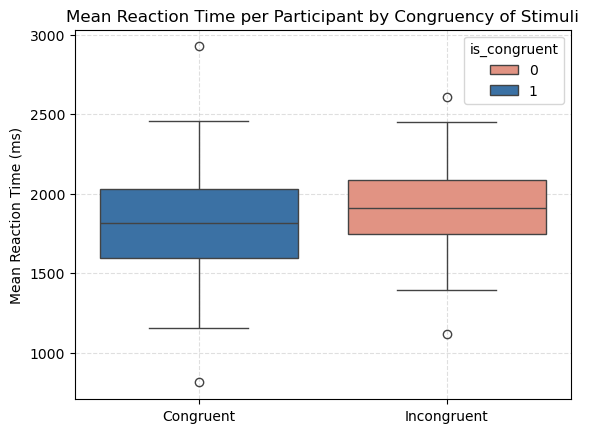

In [23]:
#Boxplots of congruent vs incongruent stimuli results
grouped = df.groupby(['participant_id', 'is_congruent'])['reaction_time'].mean().reset_index()

sns.boxplot(x='is_congruent', y='reaction_time', data=grouped, order=[1,0], hue="is_congruent", palette=["#f18973", "#2972b6"])

plt.title("Mean Reaction Time per Participant by Congruency of Stimuli")
plt.ylabel("Mean Reaction Time (ms)")

plt.xticks([0, 1], ["Congruent", "Incongruent"])

plt.xlabel("")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## Trial level

I also compared reaction times for all congruent vs. incongruent trials (across all participants), treating each trial as an independent observation.

In [26]:
# Reaction times for congruent vs incongruent stimuli
congruent_rt = df[df["is_congruent"] == 1]["reaction_time"]
incongruent_rt = df[df["is_congruent"] == 0]["reaction_time"]

To visualize the distribution of reaction times across both conditions:

### 📌 Independent T-test:

In [29]:
# Independent t-test
t_stat, p_value = ttest_ind(incongruent_rt, congruent_rt)
print(f"Independent T-test: t = {t_stat:.2f}, p = {p_value:.3f}")

Independent T-test: t = 2.51, p = 0.012


The p-value for independent t-test is **0.012**, less than 0.05. The difference remains significant even at the trial level.

### 📌 Trial-Level Boxplot:

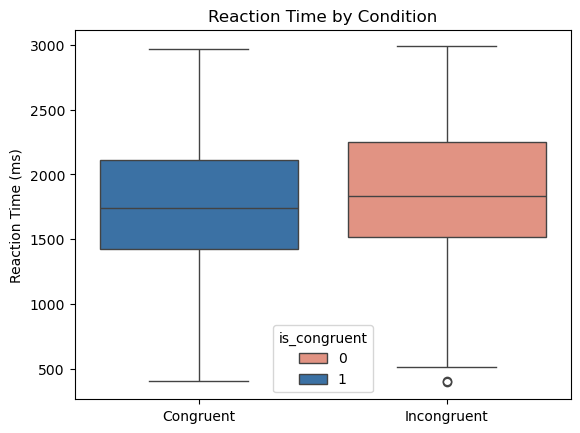

In [32]:
# Boxplot for response to congruent vs incongruent stimuli
sns.boxplot(x='is_congruent', y='reaction_time', data=df, order=[1,0], hue="is_congruent", palette=["#f18973", "#2972b6"])
plt.title("Reaction Time by Condition")
plt.ylabel("Reaction Time (ms)")
plt.xticks([0, 1], ["Congruent", "Incongruent"])
plt.xlabel("")
plt.show()

### 📌 Inference

Participants, on average, responded significantly faster to congruent stimuli than incongruent ones. This effect is statistically significant at both the participant and trial levels.Both parametric (t-tests) and non-parametric (Wilcoxon) tests confirmed this difference. Hence, we can conclude that this experiment demonstrates the Stroop Effect.

Visualization through histograms and boxplots reinforced the magnitude and direction of this effect.

# Accuracy vs Reaction Time (Speed-Accuracy Tradeoff)

I analyzed whether faster responses were associated with lower accuracy, both across participants and within individual trials. 

## Participant-level:

I examined each participant’s mean reaction time and mean accuracy to identify broad patterns. 

### 📌 Correlation test for reaction time and accuracy

In [214]:
#Correlation between reaction time and accuracy per participant
corr1 = participant_summary["mean_rt"].corr(participant_summary["accuracy"])
print(f"Participant-level correlation between reaction time and accuracy: {corr1:.3f}")

Participant-level correlation between reaction time and accuracy: 0.041


The participant-level correlation (r = 0.041) is small positive. Over all, there is a trend toward higher accuracy with longer reaction time.

### 📌 Boxplot

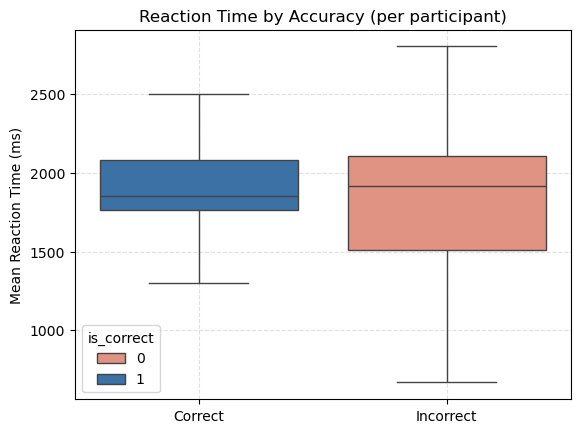

In [164]:
# Group by participant and correctness, compute mean RT
grouped_accuracy = df.groupby(['participant_id', 'is_correct'])['reaction_time'].mean().reset_index()

# Plot boxplot
sns.boxplot(x='is_correct', y='reaction_time', data=grouped_accuracy, order=[1, 0], hue="is_correct", palette=["#f18973", "#2972b6"])

plt.title("Reaction Time by Accuracy (per participant)")
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.ylabel("Mean Reaction Time (ms)")
plt.xlabel("")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## Trial level 

I also assessed whether accuracy varied by response at the trial level.

### 📌 Correlation test

In [216]:
#Correlation between reaction time and accuracy
corr2 = df['reaction_time'].corr(df['is_correct'])
print(f"Trial-level correlation between reaction time and accuracy: {corr2:.3f}")

Trial-level correlation between reaction time and accuracy: 0.100


On a trial-by-trial basis, a weak positive correlation (r = 0.10) was observed between reaction time and accuracy.

### 📌 Boxplot

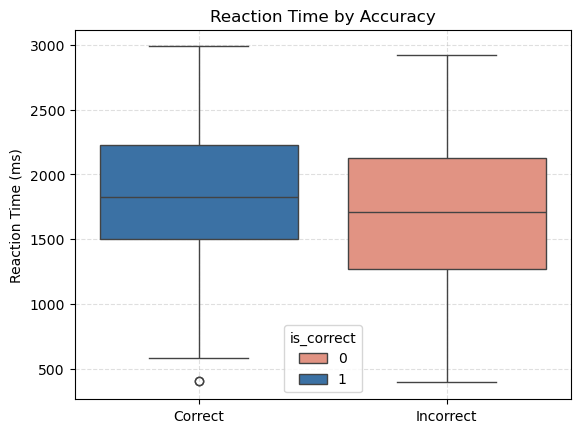

In [44]:
sns.boxplot(x='is_correct', y='reaction_time', data=df, order=[1,0], hue="is_correct", palette=["#f18973", "#2972b6"])
plt.title("Reaction Time by Accuracy")
plt.xticks([0, 1], ["Correct", "Incorrect"])
plt.ylabel("Reaction Time (ms)")
plt.xlabel("")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show() 

### 📌 Inference

These results suggests that slightly slower responses tended to be marginally more accurate, though the effect was small and likely not practically significant.


# Heatmap of Reaction Time by Congruency and Accuracy

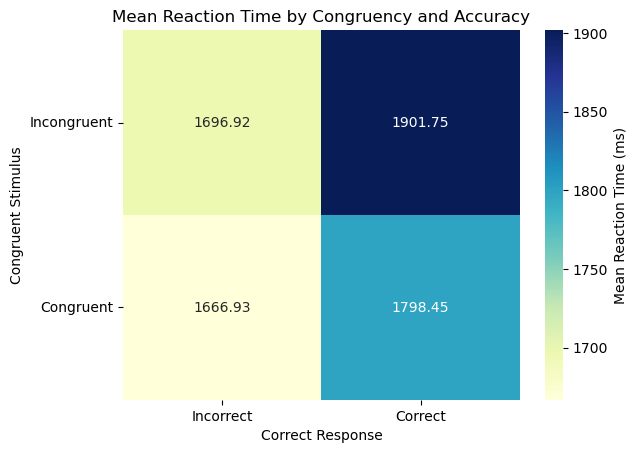

In [197]:
pivot = df.pivot_table(
    index='is_congruent', 
    columns='is_correct', 
    values='reaction_time', 
    aggfunc='mean'
)

sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Reaction Time (ms)'})
plt.title("Mean Reaction Time by Congruency and Accuracy")
plt.xlabel("Correct Response")
plt.ylabel("Congruent Stimulus")
plt.xticks([0.5, 1.5], ["Incorrect", "Correct"])
plt.yticks([0.5, 1.5], ["Incongruent", "Congruent"], rotation=0)
plt.show()

### 📌 Inference

Participants responded **fastest** on **incorrect-congruent** trials (mean RT = 1666 ms) and **slowest** on **correct-incongruent** trials (mean RT = 1901.75 ms). In simpler words, incorrect responses to congruent stimuli were the fastest, and correct responses to incongruent stimuli were the slowest. 

The former was likely due to impulsive responses while the latter was due to the increased cognitive load required to overcome the interference between word meaning and font colour, which is a hallmark of the **Stroop interference effect**.

# Trends over time 

## Participants' reaction times over trials

I observed the trends in reaction time and accuracy over the course of each participant's session, and attempted to see if repeated trials would have any effect on these two paramaters.

In [170]:
# Assigning trial number to each row within each participant
df["trial_index"] = df.groupby("participant_id").cumcount() + 1

### 📌 Reaction time trends per participant

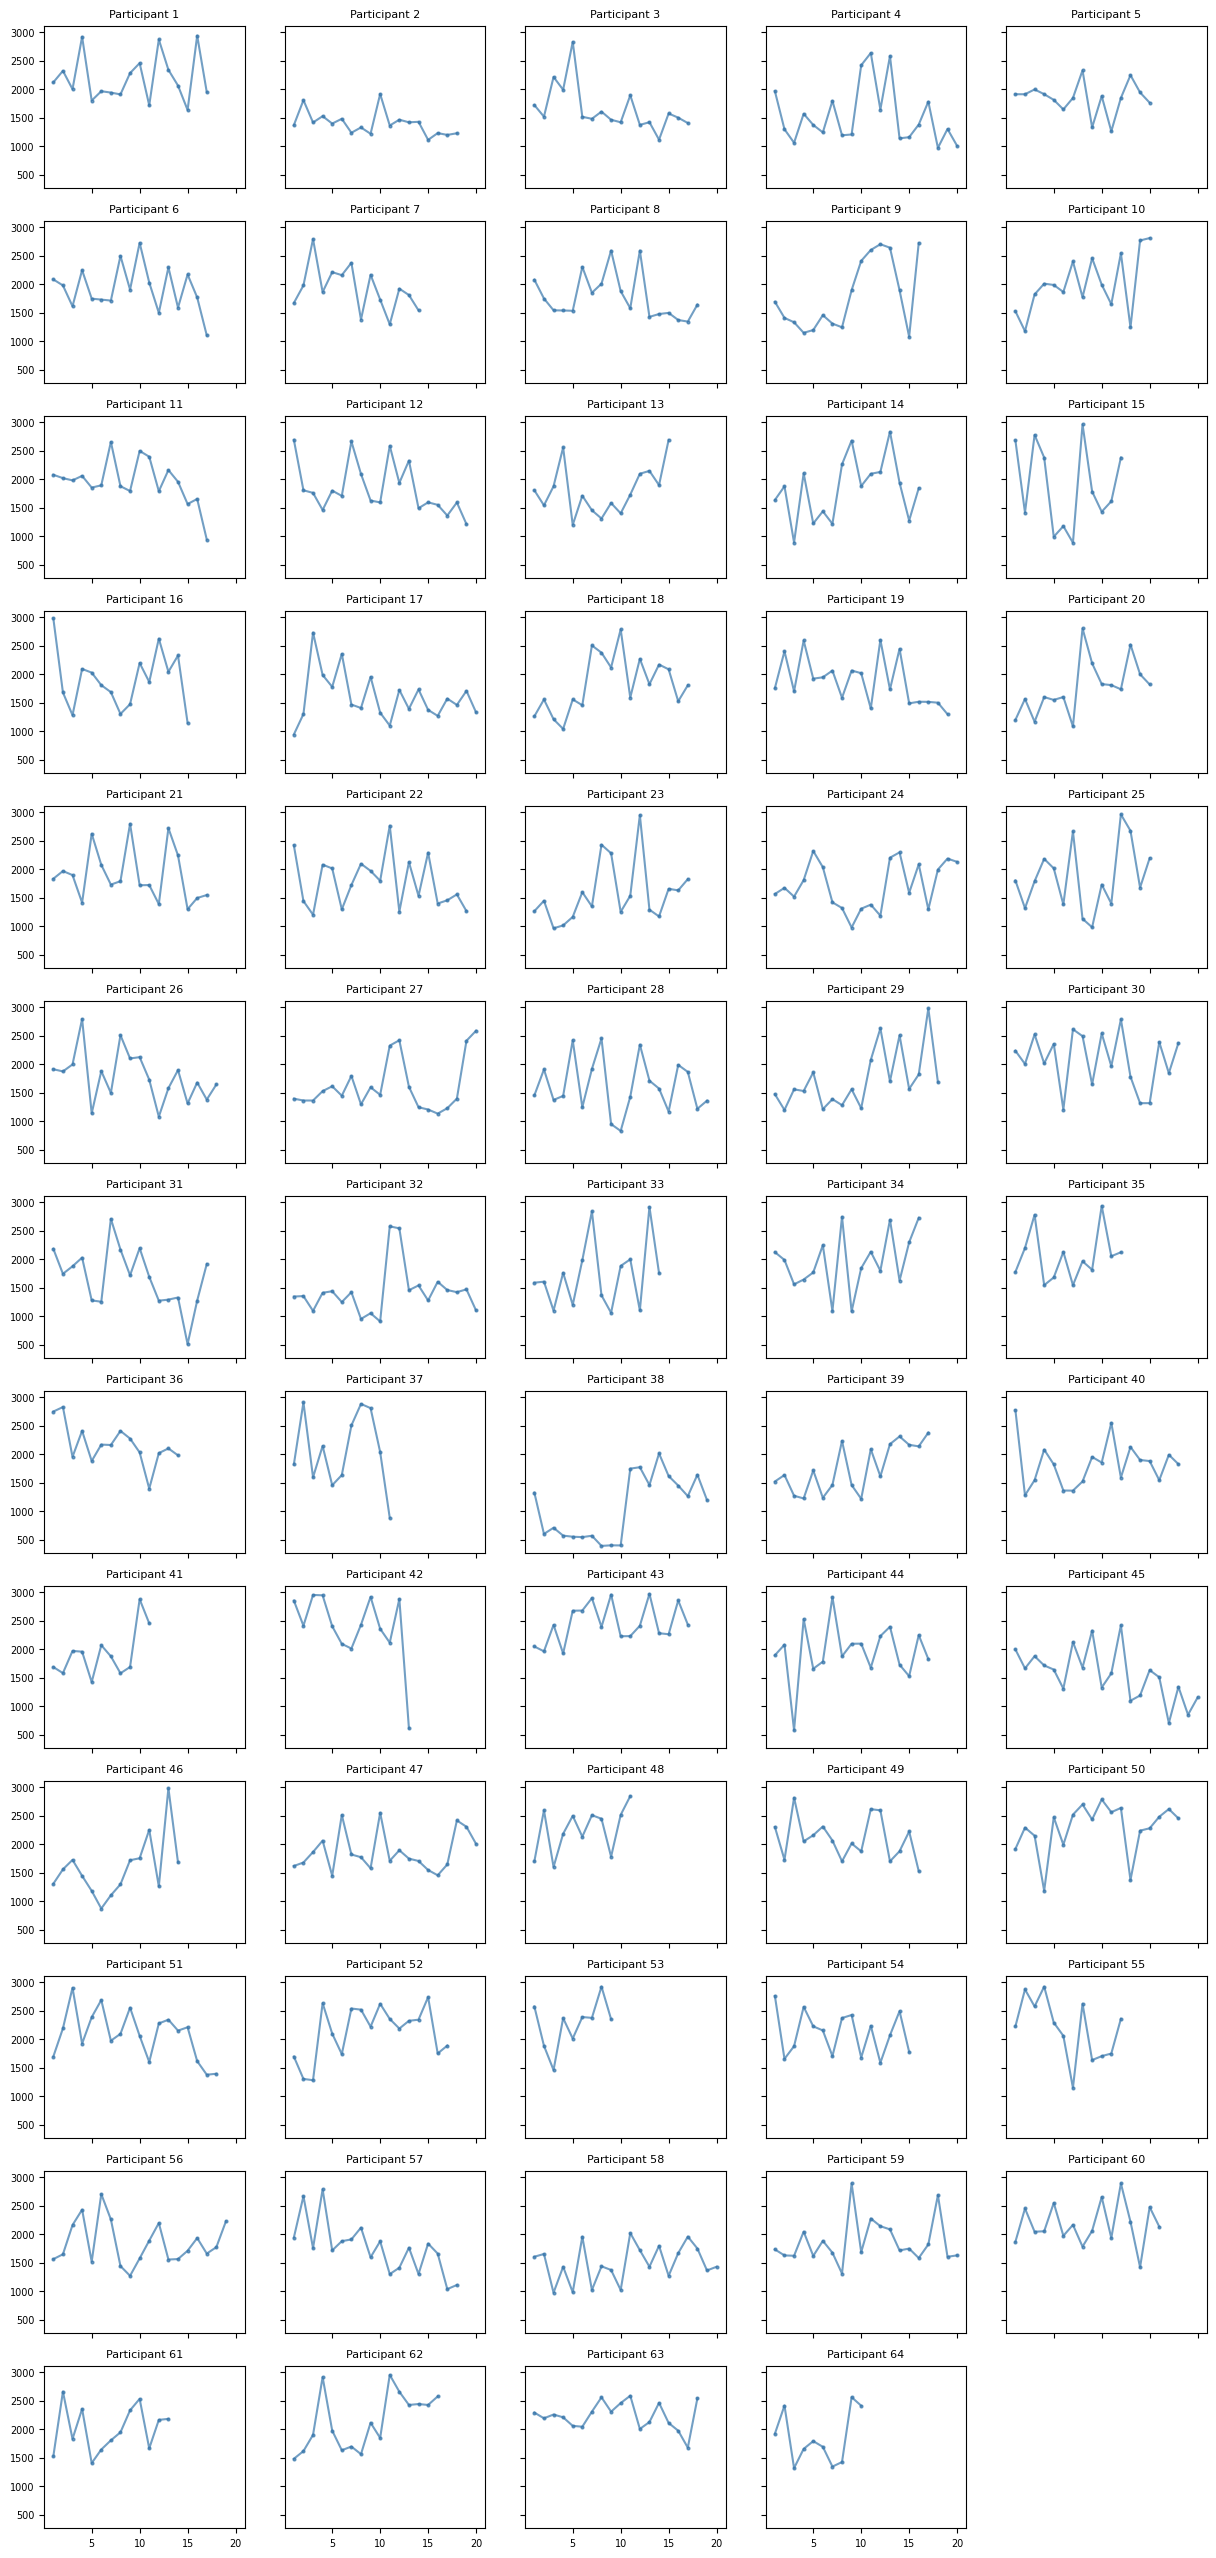

In [168]:
# Graphing trends for each participant
participant_ids = sorted(df['participant_id'].unique())
n_participants = len(participant_ids)

n_cols = 5
n_rows = (n_participants + n_cols - 1) // n_cols  # Round up
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5), sharex=True, sharey=True)

axes = axes.flatten()

for i, pid in enumerate(participant_ids):
    ax = axes[i]
    participant_data = df[df['participant_id'] == pid]
    
    ax.plot(participant_data['trial_index'], participant_data['reaction_time'],
            marker='o', linestyle='-', color="#3776ab", alpha=0.7, markersize=2)
    
    ax.set_title(f"Participant {pid + 1}", fontsize=8)
    ax.tick_params(axis='both', labelsize=7)

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

In [172]:
# Slope of each participant
slopes = []
for pid, group in df.groupby("participant_id"):
    slope, _, _, _, _ = linregress(group["trial_index"], group["reaction_time"])
    slopes.append({"participant_id": pid, "slope": slope})

trend_df = pd.DataFrame(slopes)
print(trend_df.head())

   participant_id      slope
0               0   3.553922
1               1 -17.304438
2               2 -39.973039
3               3 -10.157895
4               4  -5.603571


### 📌 Observing whether participants became slower or faster with time

In [174]:
num_faster = (trend_df["slope"] < 0).sum()
num_slower = (trend_df["slope"] > 0).sum()

print(f"Participants getting faster: {num_faster}")
print(f"Participants getting slower: {num_slower}")

Participants getting faster: 30
Participants getting slower: 34


### 📌 One sample t-test

In [176]:
t_stat, p_value = ttest_1samp(trend_df["slope"], 0)
print(f"One-sample t-test on slopes: t = {t_stat:.3f}, p = {p_value:.3f}")

One-sample t-test on slopes: t = 1.081, p = 0.284


### 📌 Inference

I observed a near-even split in slope direction among participants, there is no dominant direction. This suggests individual differences in attention, fatigue, or learning during the Stroop test.

The one-sample t-test also returns p = 0.284, indicating the participant-level trend is not statistically significant for reaction time over multiple trials. 



## Participant accuracy over trials

To investigate whether participants became more accurate over time, I fitted a logistic regression model for each participant, predicting trial accuracy (is_correct) from trial number (trial_index).


### 📌 Participant level logistic regression

In [56]:
slopes = []

for pid, group in df.groupby("participant_id"):
    X = group["trial_index"].values.reshape(-1, 1)
    y = group["is_correct"].values

    if len(np.unique(y)) < 2: # Only includes participants with both correct and incorrect answers
        continue
    
    model = LogisticRegression(solver="liblinear")  
    model.fit(X, y)
    slope = model.coef_[0][0]
    slopes.append({"participant_id": pid, "slope": slope})
   

accuracy_trend_df = pd.DataFrame(slopes).dropna() 

In [57]:
# One-sample t-test on per-participant slopes
t_stat, p_val = ttest_1samp(accuracy_trend_df["slope"], 0)
print(f"Participant-level slope t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

Participant-level slope t-test: t = 5.589, p = 0.000


The mean slope from the participants is positive. 

One-sample t-test on slopes: t = 5.589, p = 0.000. This indicates a statistically significant trend of increasing accuracy over time across participants.

### 📌 Pooled logistic regression

In [59]:
# Pooled logistic regression
X_all = df["trial_index"].values.reshape(-1, 1)
y_all = df["is_correct"].values

model_all = LogisticRegression(solver="liblinear")
model_all.fit(X_all, y_all)

print(f"Pooled slope: {model_all.coef_[0][0]:.4f}")
print(f"Intercept: {model_all.intercept_[0]:.4f}")

Pooled slope: 0.0389
Intercept: 2.0339


I also ran a single logistic regression across all participants combined:

**Slope**: 0.0389, **intercept**: 2.0339

### 📌 Inference

The pooled model suggests that with each additional trial, the log-odds of a correct response slightly increase. This indicates a learning or adaptation effect over time.

# Heatmap of font colour vs response

In [64]:
# Create confusion matrix
conf_matrix = pd.crosstab(df["color"], df["response"])

# Optional: normalize by row to get proportions
conf_matrix_normalized = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)


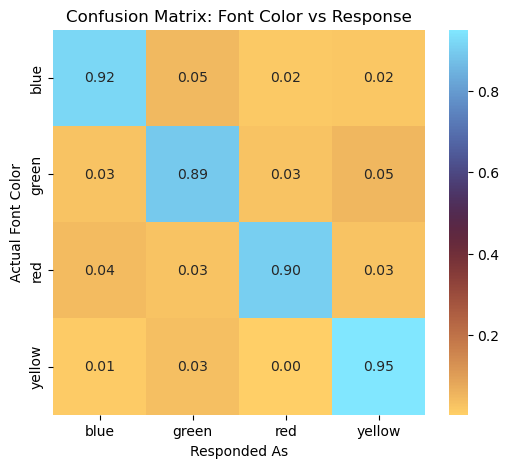

In [65]:
# Heatmap of font colour vs response
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="managua")
plt.title("Confusion Matrix: Font Color vs Response")
plt.xlabel("Responded As")
plt.ylabel("Actual Font Color")
plt.show()


Among the four colors, green showed the lowest response accuracy (89%), while yellow had the highest (95%). This may reflect perceptual confusion or stronger interference effects for the word 'GREEN'. Most errors consisted of confusing blue with green, and green with yellow (both 5%). 